**XGBoost**

In [81]:
import pandas as pd
import glob
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import precision_recall_fscore_support
from sklearn.metrics import accuracy_score
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_recall_curve
from sklearn.model_selection import RandomizedSearchCV
import xgboost as xgb
from sklearn.metrics import average_precision_score

In [82]:
dataset = pd.read_csv('dataset_anomaly_threshold_1.2.csv')

In [83]:
dataset.drop(['Unnamed: 0'], axis=1, inplace=True)

In [84]:
com_columns = dataset.columns.tolist()

In [85]:
dataset.shape[0]

3802

In [86]:
com_columns

['Wmi_SerialNumber',
 'socket',
 'channel',
 'bank',
 'Generation_x',
 'ClusterType_x',
 'HwSkuId_x',
 'BIOSVersion',
 'CPUID',
 'MemoryManufacturer',
 'MemoryPartNumber',
 'AgeOfDimm',
 'UEfit_sum',
 'MA_Uefit',
 'logMA_Uefit',
 'fm_nibble7_sum',
 'fm_nibble6_sum',
 'fm_nibble5_sum',
 'fm_nibble4_sum',
 'fm_nibble3_sum',
 'fm_nibble2_sum',
 'fm_nibble1_sum',
 'fm_nibble0_sum',
 'cnt_rk7_sum',
 'cnt_rk6_sum',
 'cnt_rk5_sum',
 'cnt_rk4_sum',
 'cnt_rk3_sum',
 'cnt_rk2_sum',
 'cnt_rk1_sum',
 'cnt_rk0_sum',
 'diffUECount_sum',
 'DimmTemp_avg',
 'TotalDIMMCount_sum',
 'repeatue_sum',
 'z_ma_uefit',
 'anomaly_label',
 'anomaly_id']

In [87]:
subset_cols = ['AgeOfDimm', 'MemoryManufacturer','diffUECount_sum', 'TotalDIMMCount_sum', 'fm_nibble7_sum', 'fm_nibble6_sum', 'fm_nibble5_sum', 'fm_nibble4_sum', 'fm_nibble3_sum', 'fm_nibble2_sum', 'fm_nibble1_sum','fm_nibble0_sum', 'cnt_rk7_sum', 'cnt_rk6_sum', 'cnt_rk5_sum', 'cnt_rk4_sum', 'cnt_rk3_sum', 'cnt_rk2_sum', 'cnt_rk1_sum', 'cnt_rk0_sum', 'DimmTemp_avg', 'repeatue_sum', 'anomaly_label']
dataset_sub = dataset[subset_cols]

In [88]:
encoder = OneHotEncoder(sparse=False, handle_unknown='ignore')
    
dataset_encoded = pd.DataFrame(encoder.fit_transform(dataset_sub[['MemoryManufacturer']]))
dataset_encoded.columns = encoder.get_feature_names(['MemoryManufacturer'])
dataset_sub.drop(['MemoryManufacturer'], axis=1, inplace=True)
    
dataset_sub_enc = pd.concat([dataset_encoded, dataset_sub], axis=1)

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



In [89]:
X = dataset_sub_enc.drop(axis=1, labels=['anomaly_label'])
y = dataset_sub_enc['anomaly_label']

#X_train, X_test, y_train, y_test = train_test_split(X.values, y.values, test_size=0.3, random_state=42)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

print(y.value_counts())

0    3454
1     348
Name: anomaly_label, dtype: int64


In [90]:
X_train.shape[0]

2661

In [91]:
algorithm_stats = pd.DataFrame()

In [92]:
def print_report(y_true, y_pred):
    print('Accuracy: %.4f\n' % (accuracy_score(y_true, y_pred)))
    print('Classification Report:')
    print(classification_report(y_true, y_pred, target_names=['Non-Anomaly', 'Anomaly']))
    #print(confusion_matrix(y_true, y_pred))
    cm = pd.DataFrame(confusion_matrix(y_true, y_pred))
    cm['Total'] = np.sum(cm, axis=1)
    cm = cm.append(np.sum(cm, axis=0), ignore_index=True)
    cm.columns = ['Predicted Non-Anomaly', 'Predicted Anomaly', 'Total']
    cm = cm.set_index([['Actual Non-Anomaly', 'Actual Anomaly', 'Total']])
    print(cm)

def create_stats(y_true, y_pred):
    acc = accuracy_score(y_true, y_pred)
    stats = precision_recall_fscore_support(y_true, y_pred, average='weighted')
    return pd.Series([acc, stats[0], stats[1], stats[2]], index=['Accuracy', 'Precision', 'Recall', 'F1'])

In [93]:
parameters = {'XGBoost__booster': ['gbtree', 'gblinear', 'dart'],
              'XGBoost__learning_rate': [0.001, 0.1, 0.2, 0.3],
              'XGBoost__n_estimators': [int(x) for x in np.linspace(start = 100, stop = 1000, num = 10)],
              'XGBoost__subsample': np.arange(0.5, 1, 0.05),
              'XGBoost__max_depth': np.arange(3, 20, 1),
              'XGBoost__colsample_bytree': np.arange(0.1, 1.05, 0.05),
              'XGBoost__objective': ['reg:logistic','binary:logistic'],
              'XGBoost__eval_metric': ['error', 'logloss'],
              'gamma':[i/10.0 for i in range(0,5)],
              'reg_alpha':[1e-5, 1e-2, 0.1, 1, 100]
              }


clf_xg = RandomizedSearchCV(
    estimator=xgb.XGBClassifier(verbose=True), 
    param_distributions=parameters, 
    n_iter=100,
    cv=10,
    #scoring='f1'
)

clf_xg.fit(X_train, y_train)

print(f'Best  score: {clf_xg.best_score_}')
print(f'Best params: {clf_xg.best_params_}\n')

algorithm_stats['RandomForest'] = create_stats(y_test, clf_xg.predict(X_test))
print_report(y_test, clf_xg.predict(X_test))

#print('Tuned Model Parameters: {}'.format(clf_xg.best_params_))

Best  score: 0.9853439779223339
Best params: {'reg_alpha': 0.01, 'gamma': 0.2, 'XGBoost__subsample': 0.7500000000000002, 'XGBoost__objective': 'binary:logistic', 'XGBoost__n_estimators': 900, 'XGBoost__max_depth': 4, 'XGBoost__learning_rate': 0.1, 'XGBoost__eval_metric': 'logloss', 'XGBoost__colsample_bytree': 0.3500000000000001, 'XGBoost__booster': 'dart'}

Accuracy: 0.9798

Classification Report:
              precision    recall  f1-score   support

 Non-Anomaly       0.98      1.00      0.99      1041
     Anomaly       1.00      0.77      0.87       100

    accuracy                           0.98      1141
   macro avg       0.99      0.89      0.93      1141
weighted avg       0.98      0.98      0.98      1141

                    Predicted Non-Anomaly  Predicted Anomaly  Total
Actual Non-Anomaly                   1041                  0   1041
Actual Anomaly                         23                 77    100
Total                                1064                 77   1141

In [94]:
xg_clf = xgb.XGBClassifier()
xg_clf.set_params(**clf_xg.best_params_)
xg_clf.fit(X_train, y_train)

XGBClassifier(XGBoost__booster='dart',
              XGBoost__colsample_bytree=0.3500000000000001,
              XGBoost__eval_metric='logloss', XGBoost__learning_rate=0.1,
              XGBoost__max_depth=4, XGBoost__n_estimators=900,
              XGBoost__objective='binary:logistic',
              XGBoost__subsample=0.7500000000000002, base_score=0.5,
              booster='gbtree', colsample_bylevel=1, colsample_bynode=1,
              colsample_bytree=1, gamma=0.2, learning_rate=0.1,
              max_delta_step=0, max_depth=3, min_child_weight=1, missing=None,
              n_estimators=100, n_jobs=1, nthread=None,
              objective='binary:logistic', random_state=0, reg_alpha=0.01,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, ...)

In [95]:
sizes = [10, 100, 400, 800, 1200, 1600, 2000, 2394]
from sklearn.model_selection import learning_curve

train_sizes, train_scores, validation_scores = learning_curve(
    estimator=xg_clf,
    X = X_train,
    y = y_train,
    #train_sizes = sizes,
    cv = 10,
    scoring = 'f1'
)

train_score_mean = train_scores.mean(axis=1)
validation_score_mean = validation_scores.mean(axis=1)

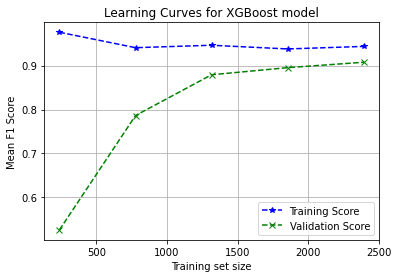

In [96]:
idx_train_size = [i for i, element in enumerate(train_score_mean) if element == 0]

if idx_train_size:
    train_sizes = np.delete(train_sizes, idx_train_size)
    train_score_mean = [i for i in train_score_mean if i != 0]
    validation_score_mean = [i for i in validation_score_mean if i != 0]

plt.plot(train_sizes, train_score_mean, marker='*', linestyle='--',color='blue',label='Training Score')
plt.plot(train_sizes, validation_score_mean, marker='x', linestyle='--', color='green',label='Validation Score')
plt.ylabel('Mean F1 Score')
plt.xlabel('Training set size')
plt.title('Learning Curves for XGBoost model')
plt.grid()
plt.legend()

In [97]:
predictions = xg_clf.predict(X_test)

In [98]:
pred_prob = xg_clf.predict_proba(X_test)[:,1]

Best Threshold=0.321821, F-Score=0.969


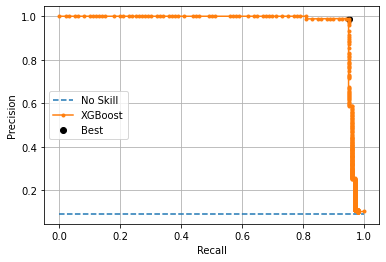

In [99]:
from numpy import argmax

# predict probabilities
#ypred = rf_clf.predict_proba(X_test)
# retrieve the probabilities for the positive class (anomaly)
#pos_probs = ypred[:, 1]
# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1])/len(y)
# plot the no skill precision-recall curve
plt.plot([0, 1], [no_skill, no_skill], linestyle='--', label='No Skill')
# calculate model precision-recall curve
precision, recall, thresholds = precision_recall_curve(y_test, pred_prob)
# convert to f score
fscore = (2*precision*recall)/(precision+recall)
# locate index of the largest f score
ix = argmax(fscore)
print('Best Threshold=%f, F-Score=%.3f' % (thresholds[ix], fscore[ix]))
# plot the model precision recall curve
plt.plot(recall, precision, marker='.', label='XGBoost')
plt.scatter(recall[ix], precision[ix], marker='o', color='black', label='Best')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.grid()
plt.savefig('XGBoost_PR_Threshold')
plt.show()

In [100]:
# apply threshold to positive probabilities to create labels
def to_labels(pos_probs, threshold):
    return(pos_probs >= threshold).astype('int')

In [101]:
from numpy import arange
from numpy import argmax
from sklearn.metrics import f1_score
# define thresholds
self_thresholds = arange(0, 1, 0.001)
# evaluate each threshold
scores = [f1_score(y_test, to_labels(pred_prob, t)) for t in self_thresholds]
# get best threshold
ix = argmax(scores)
print('Threshold=%.3f, F-Score=%.5f' % (self_thresholds[ix], scores[ix]))

Threshold=0.286, F-Score=0.96939


In [102]:
t = self_thresholds[ix]
algorithm_stats['XGBoost_NewThreshold'] = create_stats(y_test, to_labels(pred_prob, t))
print_report(y_test, to_labels(pred_prob, t))

Accuracy: 0.9947

Classification Report:
              precision    recall  f1-score   support

 Non-Anomaly       1.00      1.00      1.00      1041
     Anomaly       0.99      0.95      0.97       100

    accuracy                           0.99      1141
   macro avg       0.99      0.97      0.98      1141
weighted avg       0.99      0.99      0.99      1141

                    Predicted Non-Anomaly  Predicted Anomaly  Total
Actual Non-Anomaly                   1040                  1   1041
Actual Anomaly                          5                 95    100
Total                                1045                 96   1141


Text(0.5, 0, 'Xgboost Feature Importance')

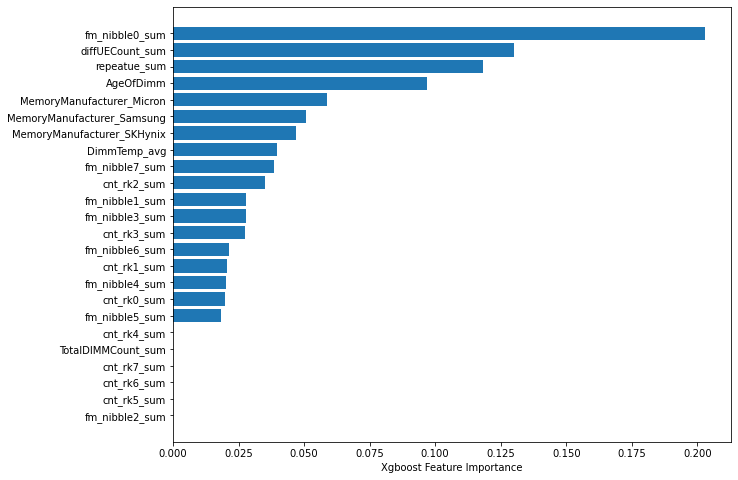

In [103]:
plt.figure(figsize=(10,8)) 
sorted_idx = xg_clf.feature_importances_.argsort()
plt.barh(X.columns[sorted_idx], xg_clf.feature_importances_[sorted_idx])
plt.xlabel("Xgboost Feature Importance")

/anaconda/envs/azureml_py36/lib/python3.6/site-packages/shap/explainers/tree.py:104: UserWarning:

Setting feature_perturbation = "tree_path_dependent" because no background data was given.



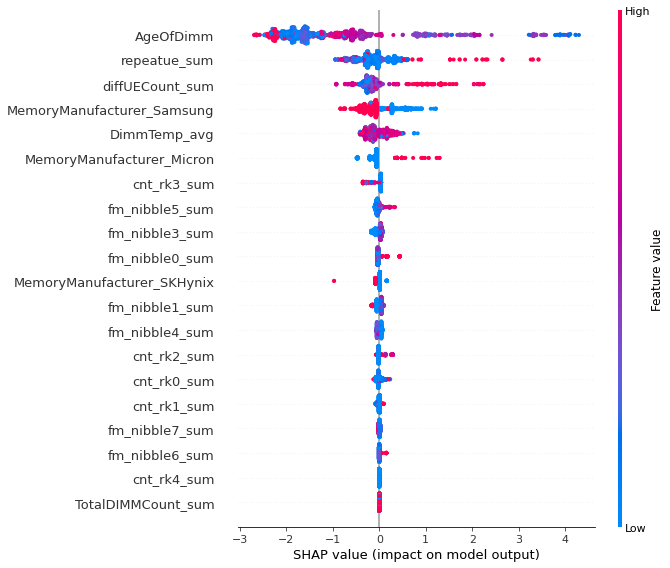

In [104]:
import shap

explainer = shap.TreeExplainer(xg_clf)
shap_values = explainer.shap_values(X_test)

shap.summary_plot(shap_values, X_test)

In [105]:
def compare_outcomes(arr1, arr2):
    if arr1 == arr2:
        return 'correct'
    else:
        return 'incorrect'

In [106]:
predict_outcomes = [1 if x >= self_thresholds[ix] else 0 for x in pred_prob]
depict_outcomes = pd.DataFrame({'predict_outcomes':predict_outcomes})
depict_outcomes['assign_outcomes'] = y_test.to_numpy()
y_test_index = y_test.index
tmp_df = dataset.iloc[y_test_index]
tmp_df = tmp_df.reset_index()
outcomes_complete = pd.concat([tmp_df, depict_outcomes], axis=1)
outcomes_complete = outcomes_complete.sort_values(by = ['AgeOfDimm'], ascending=False)
outcomes_complete['anomaly_id'] = outcomes_complete['anomaly_label'].apply(lambda x: 'outlier' if x==1 else 'inlier')
outcomes_complete['predict_id'] = outcomes_complete.apply(lambda x: compare_outcomes(x.predict_outcomes, x.assign_outcomes), axis=1)

In [107]:
outcomes_complete.drop(['index'], axis=1, inplace=True)

In [108]:
pd.set_option('display.max_columns', None)
outcomes_complete[outcomes_complete.MemoryManufacturer == 'Micron'].sort_values(by = ['AgeOfDimm'])

,Wmi_SerialNumber,socket,channel,bank,Generation_x,ClusterType_x,HwSkuId_x,BIOSVersion,CPUID,MemoryManufacturer,MemoryPartNumber,AgeOfDimm,UEfit_sum,MA_Uefit,logMA_Uefit,fm_nibble7_sum,fm_nibble6_sum,fm_nibble5_sum,fm_nibble4_sum,fm_nibble3_sum,fm_nibble2_sum,fm_nibble1_sum,fm_nibble0_sum,cnt_rk7_sum,cnt_rk6_sum,cnt_rk5_sum,cnt_rk4_sum,cnt_rk3_sum,cnt_rk2_sum,cnt_rk1_sum,cnt_rk0_sum,diffUECount_sum,DimmTemp_avg,TotalDIMMCount_sum,repeatue_sum,z_ma_uefit,anomaly_label,anomaly_id,predict_outcomes,assign_outcomes,predict_id
72,F1439C94,0.0,5.0,10.0,7.1,Compute,Lenovo-Azure-Compute-Intel-WCS-C2030,C2030.BS.2A23.AT1,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,Micron,18ASF4G72PZ-2G9E1,4,25.979138,123.400906,4.815438,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,372,1,31.2900,3196.0,0,-1.113611,0,inlier,0,0,correct
527,276E215B,0.0,0.0,6.0,6.0,Compute,Ingrasys-Azure-Compute_GP-Low-Intel-WCS-C2010,C2010.BS.3F52.AM1,Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz,Micron,36ASF4G72PZ-2G6J1,10,207.833105,122.473080,4.807891,6,6,4,6,6,2,6,4,0,0,0,0,0,0,0,40,2,33.0000,3196.0,6,-1.119963,0,inlier,0,0,correct
270,276E215B,0.0,0.0,6.0,6.0,Compute,Ingrasys-Azure-Compute_GP-Low-Intel-WCS-C2010,C2010.BS.3F52.AM1,Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz,Micron,36ASF4G72PZ-2G6J1,12,129.895691,92.782636,4.530260,6,6,4,6,6,2,6,4,0,0,0,0,0,0,0,0,3,32.4300,3196.0,2,-1.353625,0,inlier,0,0,correct
957,F1439C94,0.0,5.0,10.0,7.1,Compute,Lenovo-Azure-Compute-Intel-WCS-C2030,C2030.BS.2A23.AT1,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,Micron,18ASF4G72PZ-2G9E1,16,675.457591,204.121800,5.318717,0,1,1,0,0,1,1,0,0,0,0,0,0,0,0,3576,2,31.2900,3196.0,24,-0.690039,0,inlier,0,0,correct
319,F09B9269,1.0,0.0,14.0,6.0,Compute,Wiwynn_Azure_Gen6_GP_Med,C2010.BS.3F38.AM3,Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz,Micron,36ASF4G72PZ-2G6E1,18,51.958276,196.699189,5.281676,0,0,1,0,0,0,1,0,0,0,0,0,0,0,212,0,1,35.0000,3196.0,1,-0.721214,0,inlier,0,0,correct
431,F1439C94,0.0,5.0,10.0,7.1,Compute,Lenovo-Azure-Compute-Intel-WCS-C2030,C2030.BS.2A23.AT1,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,Micron,18ASF4G72PZ-2G9E1,19,909.269835,311.749658,5.742200,1,1,0,0,1,1,0,0,0,0,0,0,0,0,0,99,6,32.0250,3196.0,29,-0.333624,0,inlier,0,0,correct
73,F1439C94,0.0,5.0,10.0,7.1,Compute,Lenovo-Azure-Compute-Intel-WCS-C2030,C2030.BS.2A23.AT1,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,Micron,18ASF4G72PZ-2G9E1,22,6754.575913,1243.287325,7.125514,0,0,0,16,0,0,0,16,0,0,0,0,0,0,0,39552,10,33.1000,3196.0,250,0.830609,0,inlier,0,0,correct
413,244F0CD0,0.0,3.0,14.0,6.0,Compute,Wiwynn_Azure_Gen6_GP_Med,C2010.BS.3F38.AM3,Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz,Micron,36ASF4G72PZ-2G6E1,25,467.624486,1399.162153,7.243629,0,3,0,0,0,3,0,0,0,0,0,0,0,0,0,0,3,36.0000,3196.0,15,0.930017,0,inlier,0,0,correct
470,244F0CD0,0.0,3.0,14.0,6.0,Compute,Wiwynn_Azure_Gen6_GP_Med,C2010.BS.3F38.AM3,Intel(R) Xeon(R) Platinum 8171M CPU @ 2.60GHz,Micron,36ASF4G72PZ-2G6E1,28,4260.578653,1941.012749,7.570965,0,0,0,6,0,0,0,6,0,0,0,0,0,0,144,0,10,29.8000,3196.0,154,1.205512,1,outlier,0,1,incorrect
747,F1439C94,0.0,5.0,10.0,7.1,Compute,Lenovo-Azure-Compute-Intel-WCS-C2030,C2030.BS.2A23.AT1,Intel(R) Xeon(R) Platinum 8272CL CPU @ 2.60GHz,Micron,18ASF4G72PZ-2G9E1,29,467.624486,1992.971025,7.597382,2,0,0,0,2,0,0,0,0,0,0,0,0,0,0,3088,2,28.5000,3196.0,16,1.227745,1,outlier,0,1,incorrect


In [109]:
import plotly.express as px
from plotly.subplots import make_subplots
import plotly.graph_objects as go

In [110]:
fig = px.scatter(outcomes_complete[outcomes_complete.MemoryManufacturer == 'SKHynix'],x='AgeOfDimm',y='MA_Uefit',color='anomaly_id')

fig.show()

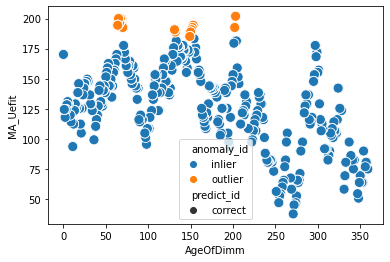

In [111]:
tmp_plot_df = outcomes_complete[outcomes_complete.MemoryManufacturer == 'Samsung']
sns.scatterplot(x = 'AgeOfDimm', y = 'MA_Uefit', s=100, hue = 'anomaly_id', style = 'predict_id', data=tmp_plot_df)
plt.show()